In [1]:
import mocet
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs
subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()

task = configs['task']
calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
calibration_threshold = configs['calibration_threshold']
px_per_deg = configs['px_per_deg']
avg_pupil_diameter_mm = configs['avg_pupil_diameter_mm']
calibration_coordinates = configs['calibration_coordinates']
calibration_order = configs['calibration_order']

valid_data = pickle.load(open('../../data/valid_data_list.pkl', 'rb'))

subjects = []
subjects_runs = {}
for key in list(valid_data.keys()):
    subjects.append(key[0])
    if not subjects_runs.keys().__contains__(key[0]):
        subjects_runs[key[0]] = 0
    subjects_runs[key[0]] += 1
subjects = list(set(subjects))
subjects.sort()

In [33]:
import os
import mocet

basis_params = np.load('../../data/simulation/basis_params.npy')
basis_data = pickle.load(open('../../data/simulation/basis_data.pkl', 'rb'))

def get_simulation_accuracy(subject, session, task, run):
    root = f'../../data/simulation/1.0/{subject}/{session}'
    simulation_fname = f'{root}/{subject}_{session}_{task}_{run}_simulation-eyetracking.csv'
    simulation_data = pd.read_csv(simulation_fname)

    model_pupil_data, model_pupil_size = np.zeros((510, 2)), np.zeros((510, 1))
    model_pupil_data[:, 0] = simulation_data['center_x']
    model_pupil_data[:, 1] = simulation_data['center_y']
    model_pupil_size[:, 0] = simulation_data['diameter_px']

    avg_pupil_diameter_mm = 5
    pupil_diameter_mm_per_px = avg_pupil_diameter_mm / np.nanmean(model_pupil_size)
    pupil_data_new = np.zeros_like(model_pupil_data)
    pupil_data_new[:, 0] = model_pupil_data[:, 0] - np.mean(model_pupil_data[:25, 0])
    pupil_data_new[:, 1] = model_pupil_data[:, 1] - np.mean(model_pupil_data[:25, 1])
    model_pupil_data = pupil_data_new * pupil_diameter_mm_per_px

    t_cal = 0
    t_val = 1
    offset = calibration_onsets[t_cal]
    calibration_pupils = []
    for i in np.arange(calibration_points[t_cal]):
        start = (offset + i)
        calibration_pupils.append(
            [np.nanmean(model_pupil_data[start, 0]), np.nanmean(model_pupil_data[start, 1])])
    calibration_pupils = np.array(calibration_pupils)

    repeat = True if calibration_points[t_cal] == 24 else False
    calibrator = mocet.EyetrackingCalibration(calibration_coordinates=calibration_coordinates,
                                              calibration_order=calibration_order,
                                              repeat=repeat)
    calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1], allow_lossy_fit=True)
    gaze_coordinates = calibrator.transform(model_pupil_data)

    MSE = []
    offset = calibration_onsets[t_val]
    for i in np.arange(calibration_points[t_val]):
        ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
        ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
        start = (offset + i)
        data_x = np.nanmean(gaze_coordinates[start, 0])
        data_y = np.nanmean(gaze_coordinates[start, 1])
        MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
    validation_error = np.nanmean(MSE) / px_per_deg
    return validation_error

def get_simulation_pupil_displacement(subject, session, task, run):
    motion_param_labels = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
    root = f'{project_dir}/data/eyetracking/{subject}/{session}'
    confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'

    basis_idx = basis_data[(subject, session, task, run)]

    fmriprep_confounds = pd.read_csv(confounds_fname, delimiter='\t')
    motion_params = fmriprep_confounds[motion_param_labels]
    motion_params = np.nan_to_num(motion_params)
    motion_params = motion_params - motion_params[0, :]

    displacements = mocet.simulation.inplane_displacement(motion_params, basis_params[basis_idx])
    return displacements

In [34]:
human_accuracy = []
simulation_accuracy = []

human_displacements = []
simulation_displacements = []
for key in list(valid_data.keys()):
    subject, session, task, run = key

    human_accuracy.append(valid_data[key][2])
    simulation_accuracy.append(get_simulation_accuracy(subject, session, task, run))

    human_displacements.append(valid_data[key][3])
    simulation_displacements.append(get_simulation_pupil_displacement(subject, session, task, run))

/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=1.87083e-21): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)
/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=1.89477e-18): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)
/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=4.8809e-32): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)
/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=6.00921e-34): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)
/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/scipy/interpolate/_rbf.py:268: Lin

PearsonRResult(statistic=np.float64(0.9176892363515943), pvalue=np.float64(2.3096888567032585e-54))


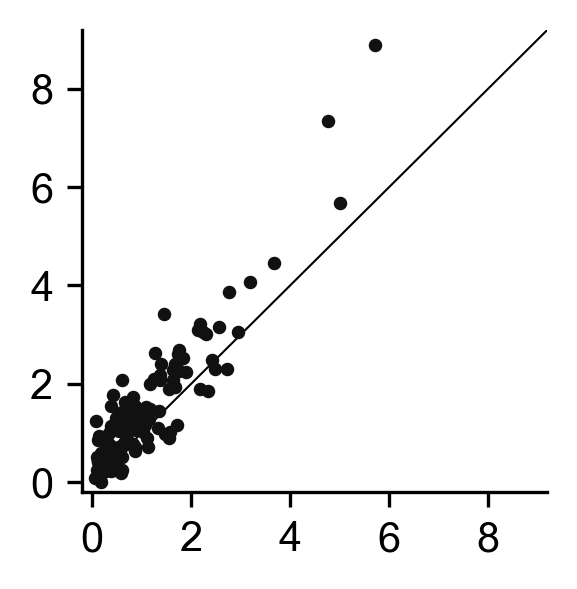

In [32]:
plt.style.use('default')
from scipy.stats import linregress, pearsonr
y = np.array(human_displacements)
x = np.array(simulation_displacements)*1000 # meter to mm
print(pearsonr(x,y))
slope, intercept, r, p, stderr = linregress(x, y)

x_range = np.linspace(0, 100, 100)

fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
ax.scatter(x, y, s=5, c='#111111', zorder=100)
ax.plot(x_range, x_range, linestyle='-', c='k', lw=0.5, zorder=2)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-0.2, 9.2)
ax.set_xticks([0,2, 4, 6,  8,])
ax.set_ylim(-0.2, 9.2)
ax.set_yticks([0,2, 4, 6,  8,])
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

TtestResult(statistic=np.float64(-12.754857232113388), pvalue=np.float64(8.858461571435936e-25), df=np.int64(132))
PearsonRResult(statistic=np.float64(0.9587738599668797), pvalue=np.float64(1.902194078070807e-73))
1.449914425851055 0.6974190781883003


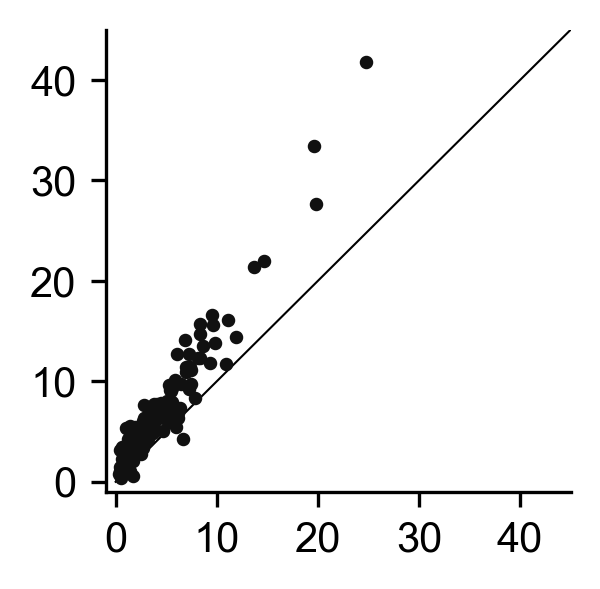

In [5]:
plt.style.use('default')
from scipy.stats import linregress, pearsonr, ttest_rel
y = np.array(human_accuracy)
x = np.array(simulation_accuracy)
print(ttest_rel(x,y))
print(pearsonr(x,y))
slope, intercept, r, p, stderr = linregress(x, y)
print(slope, intercept)

x_range = np.linspace(0, 100, 100)

fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
ax.scatter(x, y, s=5, c='#111111', zorder=100)
ax.plot(x_range, x_range, linestyle='-', c='k', lw=0.5, zorder=2)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-1, 45)
ax.set_xticks([0,10,20,30,40])
ax.set_ylim(-1, 45)
ax.set_yticks([0,10,20,30,40])
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

In [24]:
from scipy import interpolate
from scipy.stats import pearsonr

pupil_x_r = []
pupil_y_r = []

subjects_pupil_x_r = {}
subjects_pupil_y_r = {}
for subject in subjects:
    if not subjects_pupil_x_r.keys().__contains__(subject):
        subjects_pupil_x_r[subject] = []
        subjects_pupil_y_r[subject] = []

for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():

                log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
                data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
                start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

                pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                        data_fname,
                                                                                                        start=start,
                                                                                                        duration=task_duration)

                pupil_data_x = pupil_data[:,0] - np.mean(pupil_data[:int(1.6*25*60),0])
                pupil_data_y = pupil_data[:,1] - np.mean(pupil_data[:int(1.6*25*60),1])

                simulation_root = f'../../data/simulation/1.0/{subject}/{session}'
                simulation_fname = f'{simulation_root}/{subject}_{session}_{task}_{run}_simulation-eyetracking.csv'
                simulation_data = pd.read_csv(simulation_fname)

                model_pupil_data, model_pupil_size = np.zeros((510, 2)), np.zeros((510, 1))
                # Rendered image in simulation is flipped along x-axis
                model_pupil_data[:, 0] = -simulation_data['center_x']
                model_pupil_data[:, 1] = simulation_data['center_y']
                model_pupil_size[:, 0] = simulation_data['diameter_px']

                pupil_simulation_x = model_pupil_data[:, 0] - np.mean(model_pupil_data[:25, 0])
                pupil_simulation_y = model_pupil_data[:, 1] - np.mean(model_pupil_data[:25, 1])

                # downsampling
                x = np.arange(0, len(pupil_data_x))
                f = interpolate.interp1d(x, pupil_data_x)
                xnew = np.linspace(0, len(pupil_data_x) - 1, len(pupil_simulation_x))
                pupil_data_x_downsample = f(xnew)
                f = interpolate.interp1d(x, pupil_data_y)
                xnew = np.linspace(0, len(pupil_data_y) - 1, len(pupil_simulation_y))
                pupil_data_y_downsample = f(xnew)

                pupil_x_r.append(pearsonr(pupil_data_x_downsample[26:494],
                                           pupil_simulation_x[26:494])[0])
                pupil_y_r.append(pearsonr(pupil_data_y_downsample[26:494],
                                           pupil_simulation_y[26:494])[0])

                subjects_pupil_x_r[subject].append(pupil_x_r)
                subjects_pupil_y_r[subject].append(pupil_y_r)

In [25]:
null_pupil_x_r = []
null_pupil_y_r = []

for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():
                null_pupil_x_r.append([])
                null_pupil_y_r.append([])

                log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
                data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
                start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

                pupil_data, pupil_timestamps, pupil_confidence, _ = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                     data_fname,
                                                                                                     start=start,
                                                                                                     duration=task_duration)

                pupil_data_x = pupil_data[:, 0] - np.mean(pupil_data[:int(1.6 * 25 * 60), 0])
                pupil_data_y = pupil_data[:, 1] - np.mean(pupil_data[:int(1.6 * 25 * 60), 1])
                # downsampling
                x = np.arange(0, len(pupil_data_x))
                f = interpolate.interp1d(x, pupil_data_x)
                xnew = np.linspace(0, len(pupil_data_x) - 1, 510)
                pupil_data_x_downsample = f(xnew)
                f = interpolate.interp1d(x, pupil_data_y)
                xnew = np.linspace(0, len(pupil_data_y) - 1, 510)
                pupil_data_y_downsample = f(xnew)

                null_simulation_root = f'../../data/simulation_null/{subject}/{session}'
                for n in range(100):
                    null_simulation_fname = f'{null_simulation_root}/{subject}_{session}_{task}_{run}_simulation-eyetracking_null-{n:04d}.csv'
                    null_simulation_data = pd.read_csv(null_simulation_fname)

                    model_pupil_data, model_pupil_size = np.zeros((510, 2)), np.zeros((510, 1))
                    # Rendered image in simulation is flipped along x-axis
                    model_pupil_data[:, 0] = -null_simulation_data['center_x']
                    model_pupil_data[:, 1] = null_simulation_data['center_y']
                    model_pupil_size[:, 0] = null_simulation_data['diameter_px']

                    pupil_simulation_x = model_pupil_data[:, 0] - np.mean(model_pupil_data[:25, 0])
                    pupil_simulation_y = model_pupil_data[:, 1] - np.mean(model_pupil_data[:25, 1])

                    null_pupil_x_r[-1].append(pearsonr(pupil_data_x_downsample[26:494],
                                                       pupil_simulation_x[26:494])[0])
                    null_pupil_y_r[-1].append(pearsonr(pupil_data_y_downsample[26:494],
                                                       pupil_simulation_y[26:494])[0])


0.4783361026013043 0.7937246821287968


/tmp/ipykernel_3211714/1353127686.py:28: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(ax=ax, x='coordinate', y='score', hue='type',


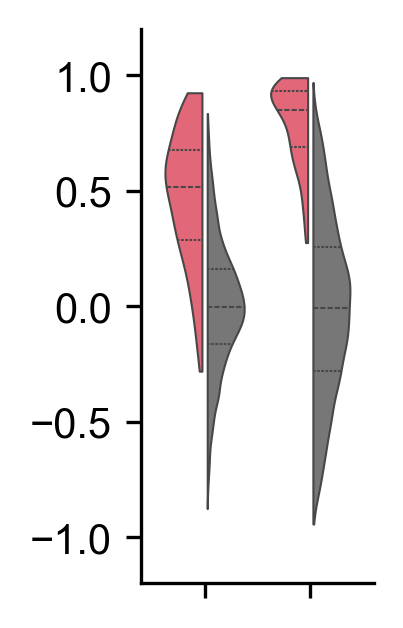

In [36]:
import seaborn as sns
plt.style.use('default')
print(np.mean(pupil_x_r), np.mean(pupil_y_r))
null_pupil_x_r_flatten = []
null_pupil_y_r_flatten = []
for i in range(len(null_pupil_x_r)):
    null_pupil_x_r_flatten += null_pupil_x_r[i]
    null_pupil_y_r_flatten += null_pupil_y_r[i]

# Create a DataFrame for seaborn
data_x = pd.DataFrame({
    'score': np.concatenate([pupil_x_r, null_pupil_x_r_flatten]),
    'type': ['actual'] * len(pupil_x_r) + ['null'] * len(null_pupil_x_r_flatten),
    'coordinate': ['x'] * (len(pupil_x_r) + len(null_pupil_x_r_flatten))
})

data_y = pd.DataFrame({
    'score': np.concatenate([pupil_y_r, null_pupil_y_r_flatten]),
    'type': ['actual'] * len(pupil_y_r) + ['null'] * len(null_pupil_y_r_flatten),
    'coordinate': ['y'] * (len(pupil_y_r) + len(null_pupil_y_r_flatten))
})

data = pd.concat([data_x, data_y])

# Plot
fig, ax = plt.subplots(figsize=(1, 2.4), dpi=300)

sns.violinplot(ax=ax, x='coordinate', y='score', hue='type',
               data=data, split=True, inner="quart", palette={"actual": "#f6546a", "null": "#777777"},
               linewidth=0.5, cut=0, scale='width', width=0.7)

# Adjust x-ticks
ax.set_xticks([0, 1])
ax.set_xticklabels(['', ''])
ax.set_xlim(-0.6, 1.6)
ax.set_ylim(-1.2, 1.2)
ax.legend([], frameon=False)
ax.set_xlabel(None)
ax.set_ylabel(None)

# Adjust the position of the violins
delta = 0.025
for ii, item in enumerate(ax.collections):
    if isinstance(item, matplotlib.collections.PolyCollection):
        path, = item.get_paths()
        vertices = path.vertices
        if ii % 2:  # -> to right
            vertices[:, 0] += delta
        else:  # -> to left
            vertices[:, 0] -= delta
for i, line in enumerate(ax.get_lines()):
    line.get_path().vertices[:, 0] += delta if i // 3 % 2 else -delta

ax.spines[['right', 'top']].set_visible(False)
plt.subplots_adjust(wspace=0.1)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
plt.show()

In [27]:
from scipy.stats import chi2, norm

# 1. Fisher's Method
def fishers_method(p_values):
    """
    Aggregate p-values using Fisher's method.
    """
    chi2_stat = -2 * np.sum(np.log(p_values))
    df = 2 * len(p_values)  # Degrees of freedom
    global_p_value = chi2.sf(chi2_stat, df)  # Survival function (1 - CDF)
    return chi2_stat, global_p_value

minimum_p_value = 1e-12

n_iterations = 100
p_values_x = []
p_values_y = []
for i in range(len(pupil_x_r)):
    actual = pupil_x_r[i]
    nulls = null_pupil_x_r[i]
    p_value = np.sum(actual <= nulls)/ n_iterations
    p_values_x.append(p_value+minimum_p_value)

for i in range(len(pupil_y_r)):
    actual = pupil_y_r[i]
    nulls = null_pupil_y_r[i]
    p_value = np.sum(actual <= nulls)/ n_iterations
    p_values_y.append(p_value+minimum_p_value)

print(np.mean(pupil_x_r), np.mean(pupil_y_r))

# Compute Fisher's global p-value
chi2_stat, fisher_global_p_value = fishers_method(np.array(p_values_x))
print(f"Fisher's Method: Chi2 Statistic = {chi2_stat:.3f}, Global p-value = {fisher_global_p_value:.5f}")

# Compute Fisher's global p-value
chi2_stat, fisher_global_p_value = fishers_method(np.array(p_values_y))
print(f"Fisher's Method: Chi2 Statistic = {chi2_stat:.3f}, Global p-value = {fisher_global_p_value:.5f}")

0.4783361026013043 0.7937246821287968
Fisher's Method: Chi2 Statistic = 5421.074, Global p-value = 0.00000
Fisher's Method: Chi2 Statistic = 7069.147, Global p-value = 0.00000
